In [187]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc,
                             classification_report, roc_auc_score)

# Görselleştirme ayarları
plt.style.use('default')
sns.set_palette("husl")

In [188]:
df = pd.read_csv("heart.csv")
# 1 = HASTA, 0 = SAĞLIKLI
df['target'] = df['target'].replace({0: 1, 1: 0})

**VERİ SETİ BİLGİLERİ**

In [189]:
print("="*80)
print("1. VERİ SETİ BİLGİLERİ")
print("="*80)

print("\n📊 Veri Seti Boyutu:")
print(f"Satır sayısı: {df.shape[0]}")
print(f"Sütun sayısı: {df.shape[1]}")

print("\n📋 İlk 5 Satır:")
print(df.head())

print("\n🔍 Sütun Bilgileri:")
print(df.info())

print("\n📈 İstatistiksel Özet:")
print(df.describe())

print("\n🏷️ Sütun Adları:")
print(df.columns.tolist())

1. VERİ SETİ BİLGİLERİ

📊 Veri Seti Boyutu:
Satır sayısı: 1025
Sütun sayısı: 14

📋 İlk 5 Satır:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       1  
1   0     3       1  
2   0     3       1  
3   1     3       1  
4   3     2       1  

🔍 Sütun Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2

**KEŞİFSEL VERİ ANALİZİ**

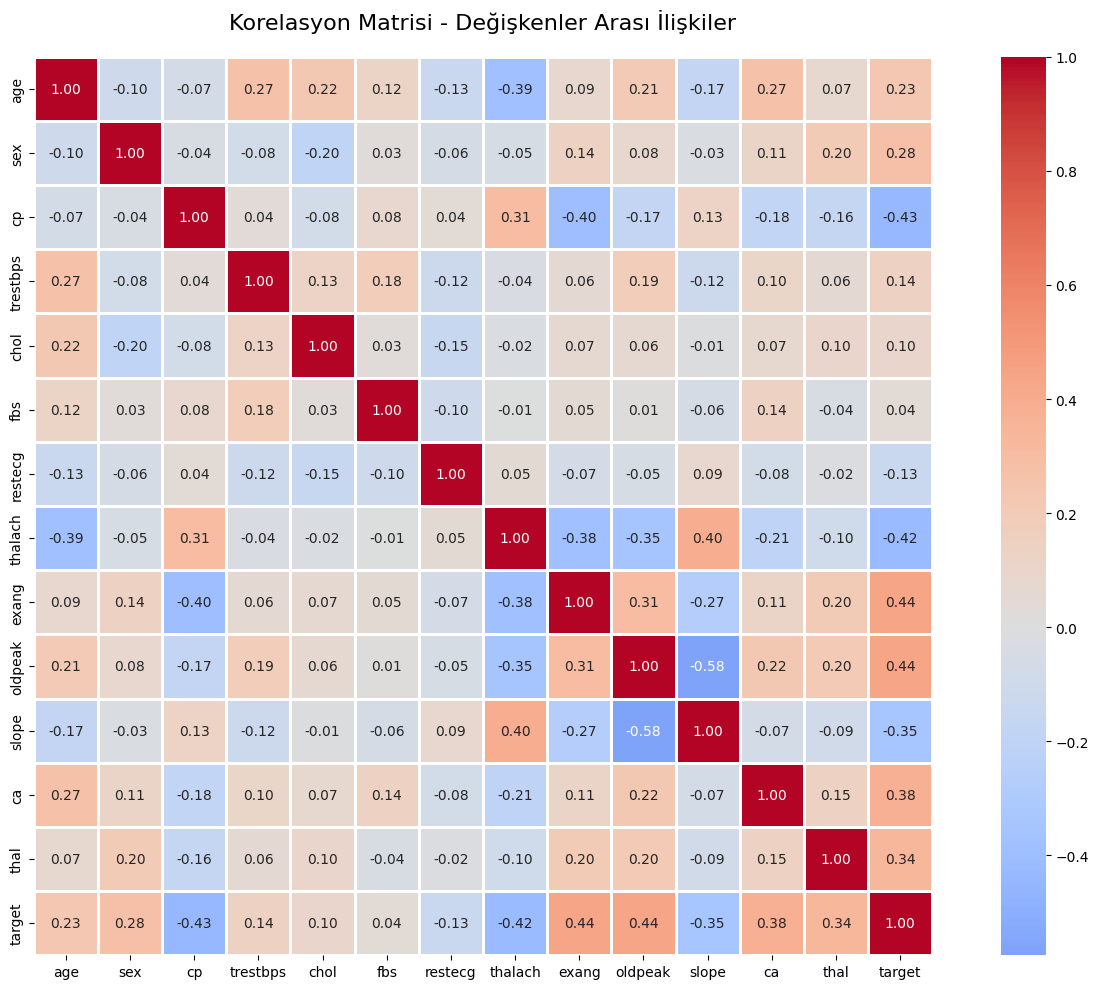

In [190]:
# Korelasyon Matrisi
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Korelasyon Matrisi - Değişkenler Arası İlişkiler', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

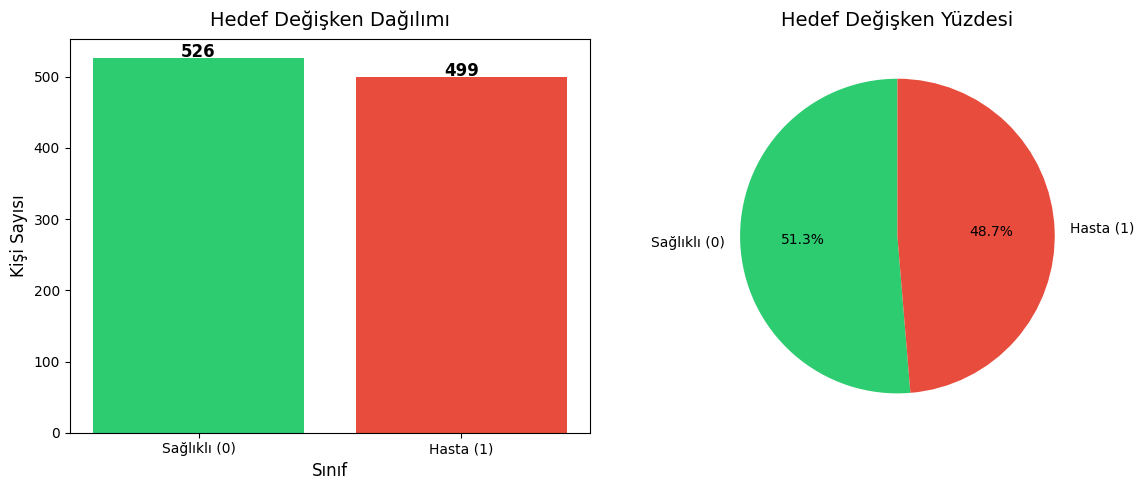


📊 Hedef Değişken Dağılımı:
Hasta (1): 499 (48.7%)
Sağlıklı (0): 526 (51.3%)


In [191]:
# Hedef değişken dağılımı
plt.figure(figsize=(12, 5))

target_counts = df['target'].value_counts().sort_index()

plt.subplot(1, 2, 1)

plt.bar(['Sağlıklı (0)', 'Hasta (1)'], target_counts.values, color=['#2ecc71','#e74c3c'])
plt.title('Hedef Değişken Dağılımı', fontsize=14, pad=10)
plt.ylabel('Kişi Sayısı', fontsize=12)
plt.xlabel('Sınıf', fontsize=12)


for i, v in enumerate(target_counts.values):
    plt.text(i, v + 2, str(v), ha='center', fontsize=12, fontweight='bold')


plt.subplot(1, 2, 2)
plt.pie(target_counts.values, labels=['Sağlıklı (0)', 'Hasta (1)'], autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'], startangle=90)
plt.title('Hedef Değişken Yüzdesi', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

print("\n📊 Hedef Değişken Dağılımı:")
print(f"Hasta (1): {target_counts[1]} ({target_counts[1]/len(df)*100:.1f}%)")
print(f"Sağlıklı (0): {target_counts[0]} ({target_counts[0]/len(df)*100:.1f}%)")

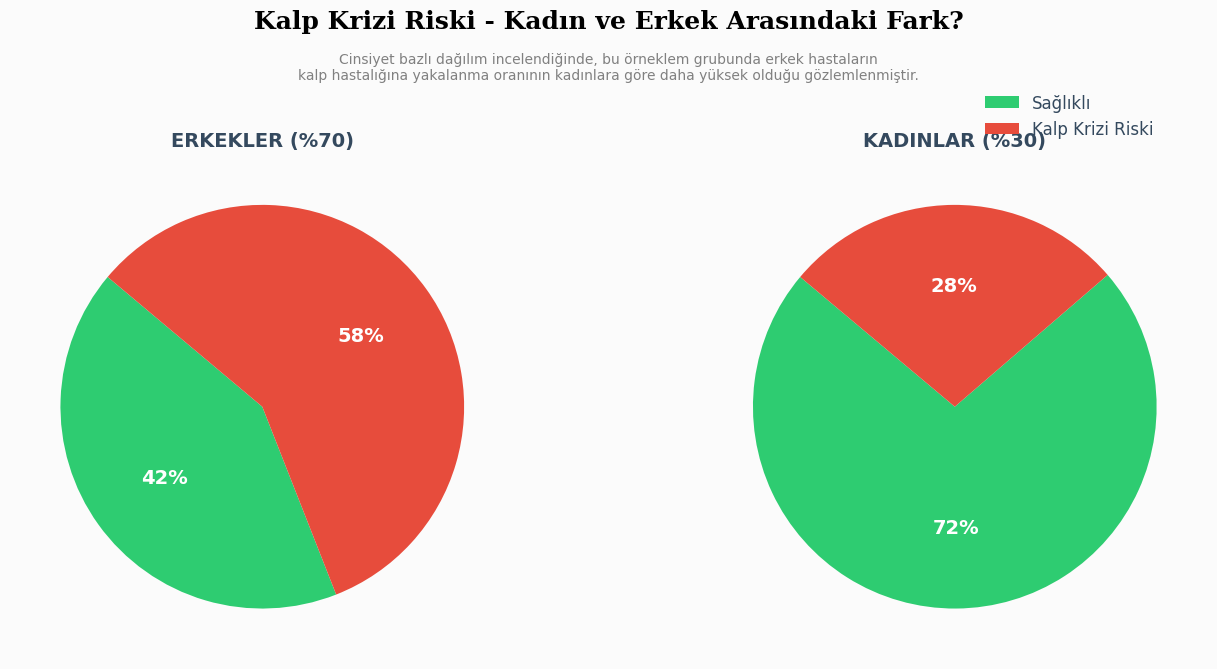

In [192]:
male_data = df[df['sex'] == 1]['target'].value_counts().sort_index().reindex([0, 1], fill_value=0)
female_data = df[df['sex'] == 0]['target'].value_counts().sort_index().reindex([0, 1], fill_value=0)

colors = ['#2ecc71', '#e74c3c']
labels = ['Sağlıklı', 'Kalp Krizi Riski']

fig, axes = plt.subplots(1, 2, figsize=(14, 7), facecolor='#fbfbfb')
fig.suptitle('Kalp Krizi Riski - Kadın ve Erkek Arasındaki Fark?', fontsize=18, fontweight='bold', fontfamily='serif')

plt.figtext(0.5, 0.88,
            "Cinsiyet bazlı dağılım incelendiğinde, bu örneklem grubunda erkek hastaların\n"
            "kalp hastalığına yakalanma oranının kadınlara göre daha yüksek olduğu gözlemlenmiştir.",
            ha="center", fontsize=10, color='gray')

wedges, texts, autotexts = axes[0].pie(
    male_data,
    labels=None,
    autopct='%1.0f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 14, 'color': 'white', 'weight': 'bold'}
)
axes[0].set_title(f'ERKEKLER (%{len(df[df.sex==1])/len(df)*100:.0f})', fontsize=14, fontweight='bold', color='#34495e')

wedges2, texts2, autotexts2 = axes[1].pie(
    female_data,
    labels=None,
    autopct='%1.0f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 14, 'color': 'white', 'weight': 'bold'}
)
axes[1].set_title(f'KADINLAR (%{len(df[df.sex==0])/len(df)*100:.0f})', fontsize=14, fontweight='bold', color='#34495e')

fig.legend(wedges, labels, loc="upper right", bbox_to_anchor=(0.9, 0.88),
           fontsize=12, frameon=False, labelcolor='#34495e')

plt.tight_layout(rect=[0, 0.03, 1, 0.85])
plt.show()

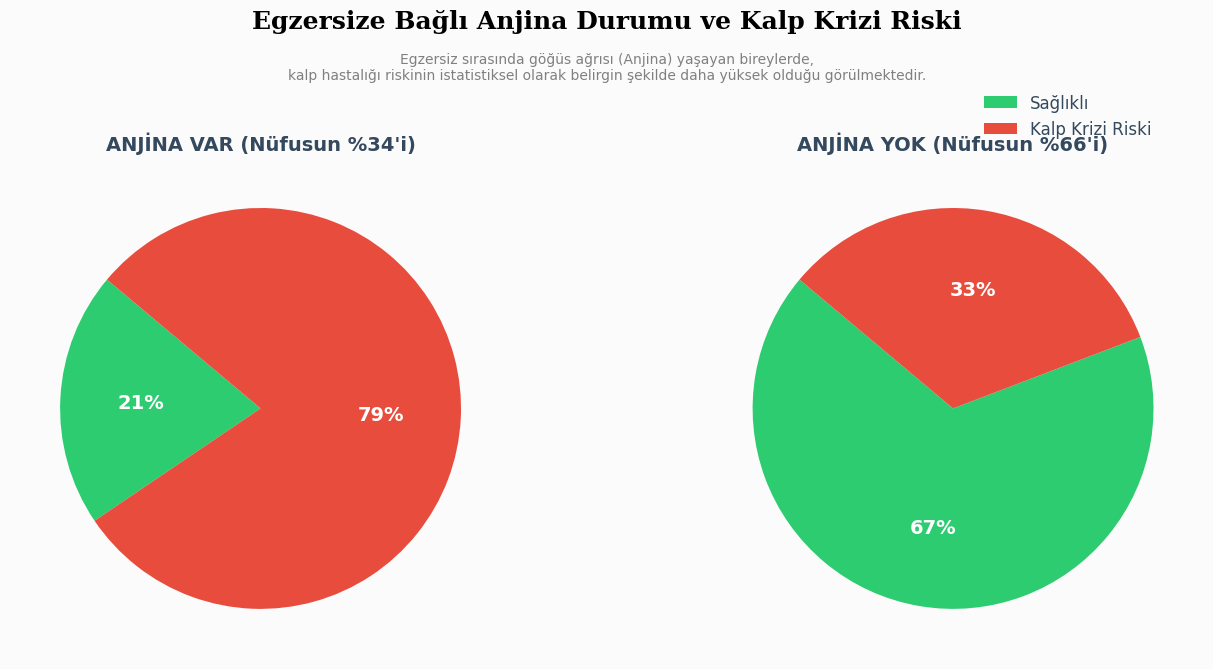

In [193]:
exang_yes_data = df[df['exang'] == 1]['target'].value_counts().sort_index()
exang_no_data = df[df['exang'] == 0]['target'].value_counts().sort_index()

exang_yes_data = exang_yes_data.reindex([0, 1], fill_value=0)
exang_no_data = exang_no_data.reindex([0, 1], fill_value=0)

colors = ['#2ecc71', '#e74c3c']
labels = ['Sağlıklı', 'Kalp Krizi Riski']

pct_yes = len(df[df['exang'] == 1]) / len(df) * 100
pct_no = len(df[df['exang'] == 0]) / len(df) * 100


fig, axes = plt.subplots(1, 2, figsize=(14, 7), facecolor='#fbfbfb')
fig.suptitle('Egzersize Bağlı Anjina Durumu ve Kalp Krizi Riski', fontsize=18, fontweight='bold', fontfamily='serif')


plt.figtext(0.5, 0.88,
            "Egzersiz sırasında göğüs ağrısı (Anjina) yaşayan bireylerde,\n"
            "kalp hastalığı riskinin istatistiksel olarak belirgin şekilde daha yüksek olduğu görülmektedir.",
            ha="center", fontsize=10, color='gray')

axes[0].pie(
    exang_yes_data,
    labels=None,
    autopct='%1.0f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 14, 'color': 'white', 'weight': 'bold'}
)
axes[0].set_title(f'ANJİNA VAR (Nüfusun %{pct_yes:.0f}\'i)', fontsize=14, fontweight='bold', color='#34495e')

axes[1].pie(
    exang_no_data,
    labels=None,
    autopct='%1.0f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 14, 'color': 'white', 'weight': 'bold'}
)
axes[1].set_title(f'ANJİNA YOK (Nüfusun %{pct_no:.0f}\'i)', fontsize=14, fontweight='bold', color='#34495e')

legend_elements = [Patch(facecolor=colors[0], label='Sağlıklı'),
                   Patch(facecolor=colors[1], label='Kalp Krizi Riski')]

fig.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(0.9, 0.88),
           fontsize=12, frameon=False, labelcolor='#34495e')

plt.tight_layout(rect=[0, 0.03, 1, 0.85])
plt.show()

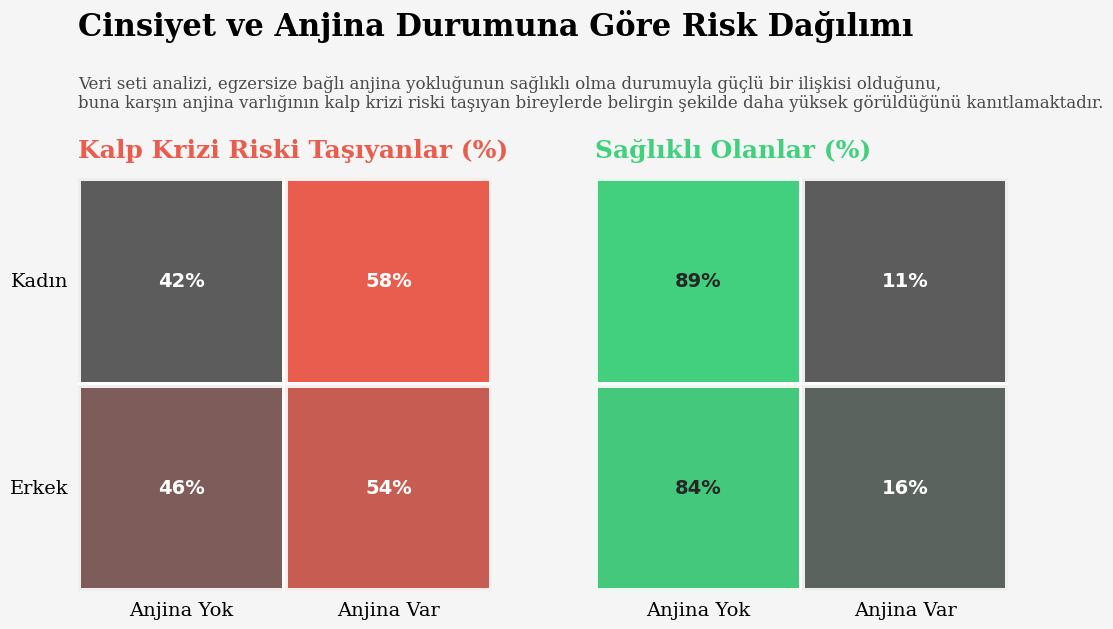

In [194]:
healthy = df[df['target'] == 0]
risk_df = df[df['target'] == 1]

risk_cross = pd.crosstab(risk_df['sex'], risk_df['exang'], normalize='index')
no_risk_cross = pd.crosstab(healthy['sex'], healthy['exang'], normalize='index')

col1 = ["#4b4b4c", "#e74c3c"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N=256)
col2 = ["#4b4b4c", "#2ecc71"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)

fig = plt.figure(figsize=(12, 6), dpi=100)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('#f6f5f5')
ax0.set_facecolor('#f6f5f5')
ax1.set_facecolor('#f6f5f5')

sns.heatmap(ax=ax0, data=risk_cross, linewidths=0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,
            linewidth=3, cmap=colormap1, annot=True, fmt='1.0%',
            annot_kws={"fontsize": 14, "fontweight": "bold"}, alpha=0.9)

sns.heatmap(ax=ax1, data=no_risk_cross, linewidths=0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,
            linewidth=3, cmap=colormap2, annot=True, fmt='1.0%',
            annot_kws={"fontsize": 14, "fontweight": "bold"}, alpha=0.9)

ax0.text(0, -0.69, 'Cinsiyet ve Anjina Durumuna Göre Risk Dağılımı',
         {'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 22})

aciklama = (
  "Veri seti analizi, egzersize bağlı anjina yokluğunun sağlıklı olma durumuyla güçlü bir ilişkisi olduğunu, \n"
  "buna karşın anjina varlığının kalp krizi riski taşıyan bireylerde belirgin şekilde daha yüksek görüldüğünü kanıtlamaktadır."
)

ax0.text(0, -0.34, aciklama, {'font': 'Serif', 'color': 'black', 'size': 12}, alpha=0.7)
ax0.text(0, -0.1, 'Kalp Krizi Riski Taşıyanlar (%)', {'font': 'serif', 'color': "#e74c3c", 'size': 18, "weight":"bold"}, alpha=0.9)
ax1.text(0, -0.1, 'Sağlıklı Olanlar (%)', {'font': 'serif', 'color': "#2ecc71", 'size': 18, "weight":"bold"}, alpha=0.9)

ax0.axes.set_xticklabels(['Anjina Yok', 'Anjina Var'], fontfamily='serif', color='black', fontsize=14)
ax1.axes.set_xticklabels(['Anjina Yok', 'Anjina Var'], fontfamily='serif', color='black', fontsize=14)

ax0.axes.set_yticklabels(['Kadın', 'Erkek'], fontfamily='serif', color='black', fontsize=14, rotation=0)

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax1.tick_params(left=False, bottom=False)

plt.show()

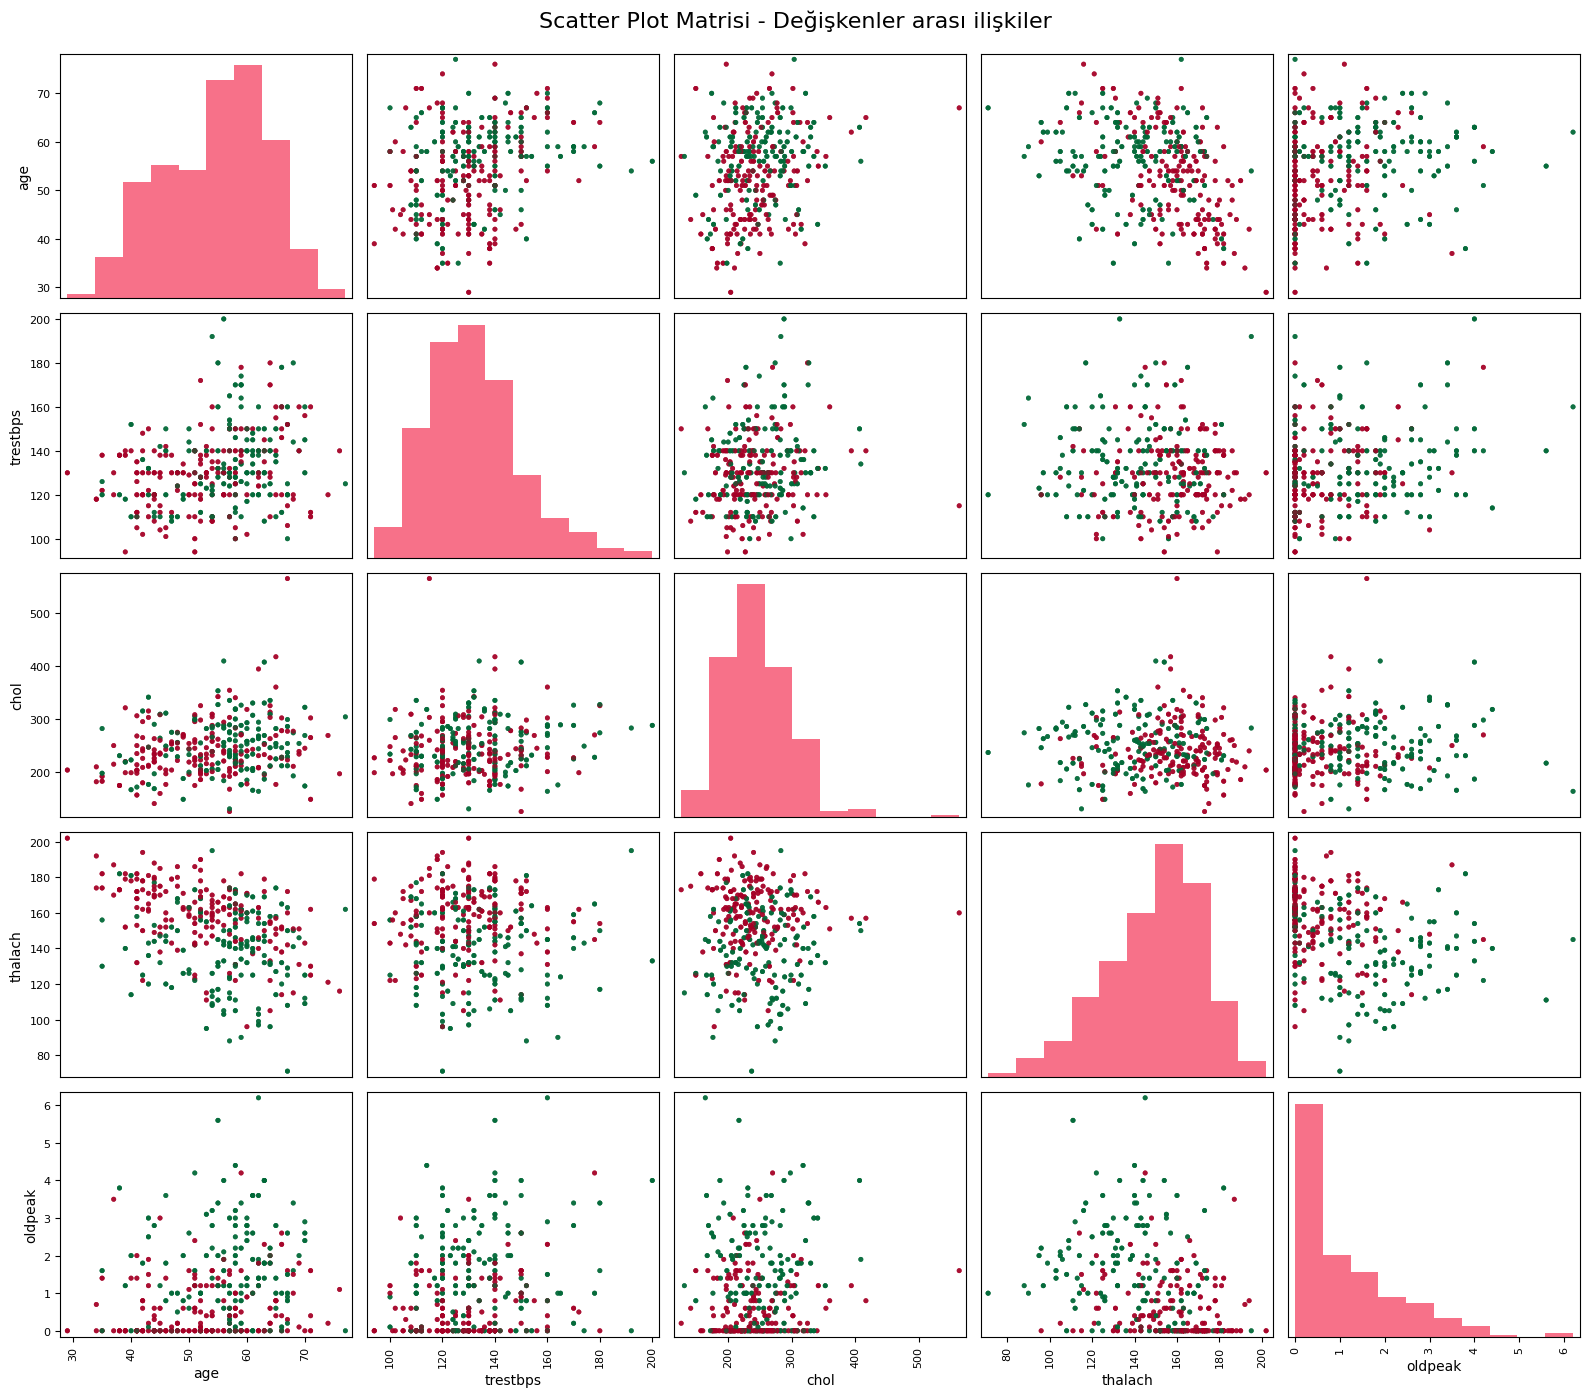

In [195]:
# Scatter Plot Matrisi (Sayısal değişkenler)
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
pd.plotting.scatter_matrix(df[num_cols], figsize=(16, 14),
                          c=df['target'], cmap='RdYlGn',
                          alpha=0.6, diagonal='hist', s=50)
plt.suptitle('Scatter Plot Matrisi - Değişkenler arası ilişkiler', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

**VERİ ÖN İŞLEME**

In [196]:
# Eksik veri kontrolü
print("\n🔍 Eksik Veri Kontrolü:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0] if missing_data.sum() > 0 else "Eksik veri bulunmamaktadır.")

# Eksik verileri ortalama ile doldurma (varsa)
if df.isnull().sum().sum() > 0:
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mean(), inplace=True)
    print("✅ Eksik veriler ortalama ile dolduruldu.")


🔍 Eksik Veri Kontrolü:
Eksik veri bulunmamaktadır.


In [197]:
# Sadece sürekli değişkenleri seçiyoruz (Kategoriklere dokunmuyoruz)
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

print("\n🔧 Aykırı Değer Temizliği:")
outliers_count = 0

for col in num_cols:
    # Sütun veri setinde var mı kontrolü (Hata almamak için)
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Alt ve üst sınırlar
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Aykırı değer sayısı
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

        if outliers > 0:
            print(f"  - {col}: {outliers} aykırı değer baskılandı (Sınırlar: {lower_bound:.1f} - {upper_bound:.1f})")
            outliers_count += outliers

            # Baskılama (Capping) İşlemi
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

if outliers_count == 0:
    print("  - Hiçbir aykırı değer tespit edilmedi.")
else:
    print(f"✅ Toplam {outliers_count} değer sınırlandırıldı.")


🔧 Aykırı Değer Temizliği:
  - trestbps: 30 aykırı değer baskılandı (Sınırlar: 90.0 - 170.0)
  - chol: 16 aykırı değer baskılandı (Sınırlar: 115.0 - 371.0)
  - thalach: 4 aykırı değer baskılandı (Sınırlar: 81.0 - 217.0)
  - oldpeak: 7 aykırı değer baskılandı (Sınırlar: -2.7 - 4.5)
✅ Toplam 57 değer sınırlandırıldı.


In [198]:
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
print(f"\n🔄 One-Hot Encoding uygulanıyor: {cat_cols}")
df = pd.get_dummies(df, columns=cat_cols, drop_first=False)
print("✅ Dönüşüm tamamlandı. Yeni sütun sayısı:", df.shape[1])
print("\n📋 Tüm Sütunların Listesi:")
print(df.columns.tolist())


🔄 One-Hot Encoding uygulanıyor: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
✅ Dönüşüm tamamlandı. Yeni sütun sayısı: 31

📋 Tüm Sütunların Listesi:
['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'fbs_0', 'fbs_1', 'restecg_0', 'restecg_1', 'restecg_2', 'exang_0', 'exang_1', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1', 'thal_2', 'thal_3']


In [199]:
# Özellik ve hedef değişkeni ayırma
X = df.drop('target', axis=1)
y = df['target']

# Eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y)

# scaler (train'e fit)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print(f"\n📊 Veri Seti Bölünmesi:")
print(f"Eğitim seti boyutu: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test seti boyutu: {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")


📊 Veri Seti Bölünmesi:
Eğitim seti boyutu: 820 (80.0%)
Test seti boyutu: 205 (20.0%)


**MODEL OLUŞTURMA VE EĞİTİM**

In [200]:
# Modeller ve hiperparametreler
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear', 'saga']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [2, 3],
            'learning_rate': [0.001, 0.01, 0.05],
            'subsample': [0.7, 0.8],
            'colsample_bytree': [0.8, 1.0],
            'reg_alpha': [0.1, 1],
            'reg_lambda': [1, 2],
            'gamma': [0.1, 0.2]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [4, 5, 6, 8],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [2, 4, 6]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 3],
            'kernel': ['rbf', 'linear'],
            'gamma': [0.1, 0.01, 0.001, 'scale', 'auto']
        }
    }
}

In [201]:
# Çapraz doğrulama ayarları
cv_folds = 5

# Model eğitimi ve hiperparametre optimizasyonu
print(f"\n🔄 Çapraz Doğrulama: {cv_folds} kat")
print("\n🚀 Model Eğitimi Başlıyor...")

trained_models = {}
best_params = {}

for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"📈 {name} Eğitiliyor...")

    # GridSearchCV ile en iyi hiperparametreleri bulma
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=cv_folds,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)

    trained_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_

    print(f"✅ En iyi parametreler: {grid_search.best_params_}")
    print(f"✅ En iyi CV skoru: {grid_search.best_score_:.4f}")

    # Çapraz doğrulama skorları
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train,
                                cv=cv_folds, scoring='accuracy')
    print(f"✅ CV skorları: {cv_scores}")
    print(f"✅ Ortalama CV skoru: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\n" + "="*60)
print("✅ Tüm modeller başarıyla eğitildi!")

from sklearn.ensemble import VotingClassifier

print("\n" + "="*60)
print("🗳️ VOTING CLASSIFIER (ORTAK AKIL) OLUŞTURULUYOR...")

voting_estimators = [
    ('lr', trained_models['Logistic Regression']),
    ('xgb', trained_models['XGBoost']),
    ('rf', trained_models['Random Forest']),
    ('svm', trained_models['SVM'])
]

voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')
voting_clf.fit(X_train, y_train)
trained_models['Voting Classifier'] = voting_clf
print("✅ Voting Classifier listeye eklendi.")


🔄 Çapraz Doğrulama: 5 kat

🚀 Model Eğitimi Başlıyor...

📈 Logistic Regression Eğitiliyor...
✅ En iyi parametreler: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
✅ En iyi CV skoru: 0.8535
✅ CV skorları: [0.85365854 0.84756098 0.86585366 0.89634146 0.84146341]
✅ Ortalama CV skoru: 0.8610 (+/- 0.0389)

📈 XGBoost Eğitiliyor...
✅ En iyi parametreler: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
✅ En iyi CV skoru: 0.9673
✅ CV skorları: [0.94512195 0.95731707 0.95731707 0.99390244 0.98780488]
✅ Ortalama CV skoru: 0.9683 (+/- 0.0381)

📈 Random Forest Eğitiliyor...
✅ En iyi parametreler: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
✅ En iyi CV skoru: 0.9639
✅ CV skorları: [0.95731707 0.93292683 0.9695122  0.97560976 0.98780488]
✅ Ortalama CV skoru: 0.9646 (+/- 0.0373)

📈 SVM Eğitiliyor...
✅ En iyi parametreler: {'C': 3,

**MODEL PERFORMANS DEĞERLENDİRMESİ**

In [202]:
# Tahminler ve metrikler
results = {}
y_probs = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'y_pred': y_pred
    }
    y_probs[name] = y_prob

    print(f"\n📊 {name} Sonuçları:")
    print(f"  Accuracy:  {results[name]['Accuracy']:.4f}")
    print(f"  Precision: {results[name]['Precision']:.4f}")
    print(f"  Recall:    {results[name]['Recall']:.4f}")
    print(f"  F1-Score:  {results[name]['F1-Score']:.4f}")


📊 Logistic Regression Sonuçları:
  Accuracy:  0.8634
  Precision: 0.8673
  Recall:    0.8500
  F1-Score:  0.8586

📊 XGBoost Sonuçları:
  Accuracy:  0.9610
  Precision: 0.9423
  Recall:    0.9800
  F1-Score:  0.9608

📊 Random Forest Sonuçları:
  Accuracy:  0.9610
  Precision: 0.9423
  Recall:    0.9800
  F1-Score:  0.9608

📊 SVM Sonuçları:
  Accuracy:  0.9707
  Precision: 0.9434
  Recall:    1.0000
  F1-Score:  0.9709

📊 Voting Classifier Sonuçları:
  Accuracy:  0.9610
  Precision: 0.9423
  Recall:    0.9800
  F1-Score:  0.9608


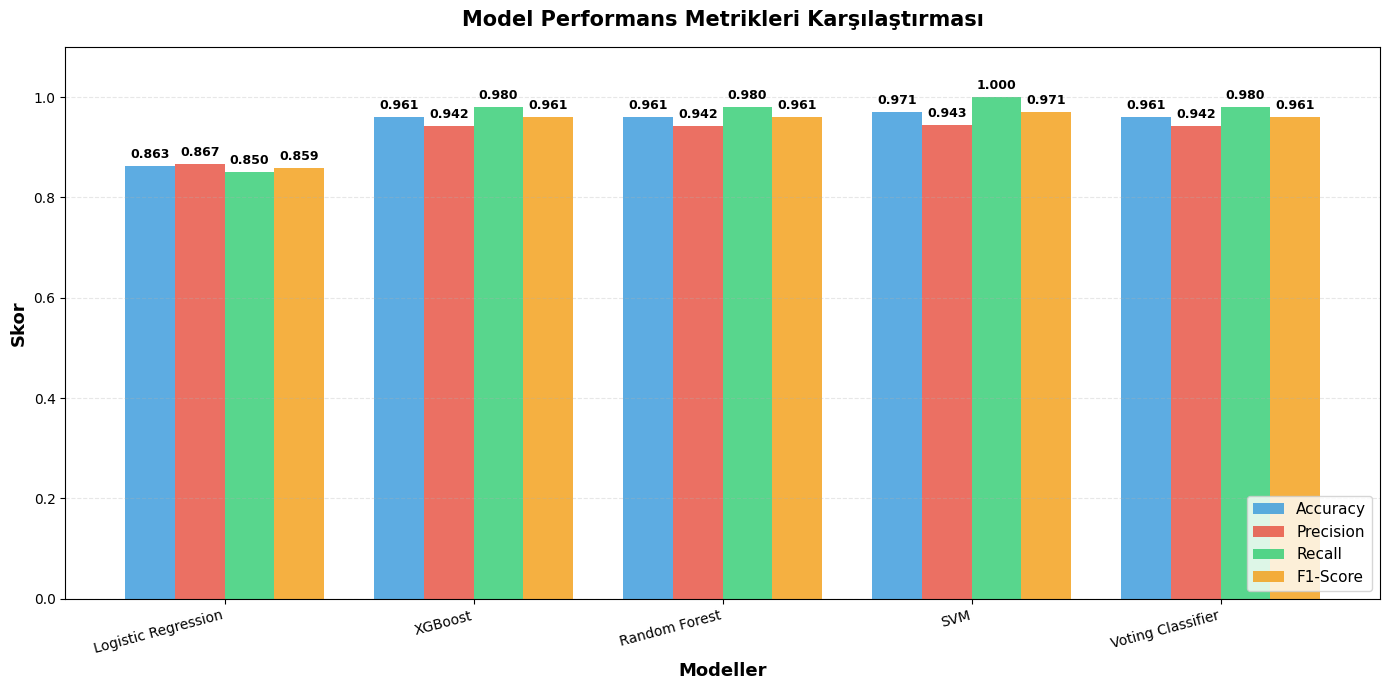

In [203]:
# Performans Metrikleri Karşılaştırma Grafiği
metrics_df = pd.DataFrame(results).T[['Accuracy', 'Precision', 'Recall', 'F1-Score']]

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(metrics_df.index))
width = 0.2

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
for i, metric in enumerate(metrics_df.columns):
    ax.bar(x + i * width, metrics_df[metric], width,
           label=metric, color=colors[i], alpha=0.8)

    # Değerleri gösterme
    for j, v in enumerate(metrics_df[metric]):
        ax.text(j + i * width, v + 0.01, f'{v:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Modeller', fontsize=13, fontweight='bold')
ax.set_ylabel('Skor', fontsize=13, fontweight='bold')
ax.set_title('Model Performans Metrikleri Karşılaştırması', fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics_df.index, rotation=15, ha='right')
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

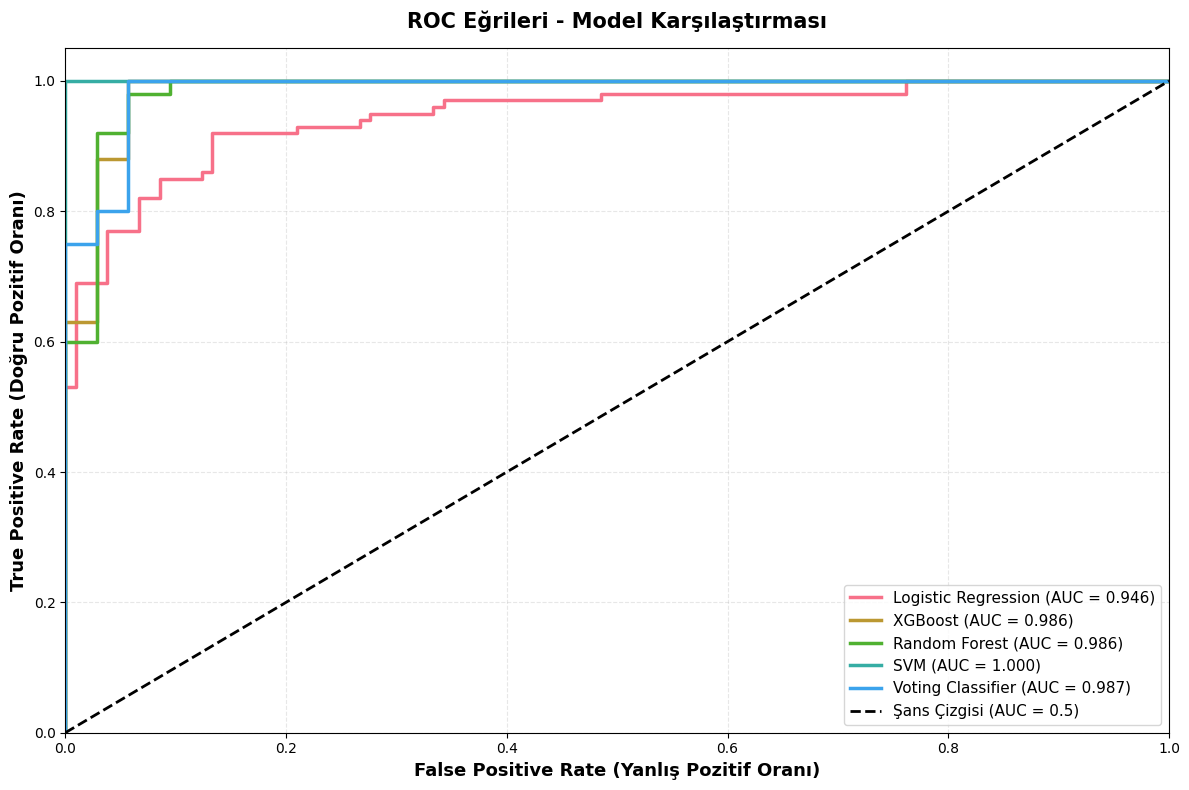

In [204]:
# ROC Eğrileri
plt.figure(figsize=(12, 8))

for name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2.5,
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Şans Çizgisi (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Pozitif Oranı)', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Doğru Pozitif Oranı)', fontsize=13, fontweight='bold')
plt.title('ROC Eğrileri - Model Karşılaştırması', fontsize=15, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

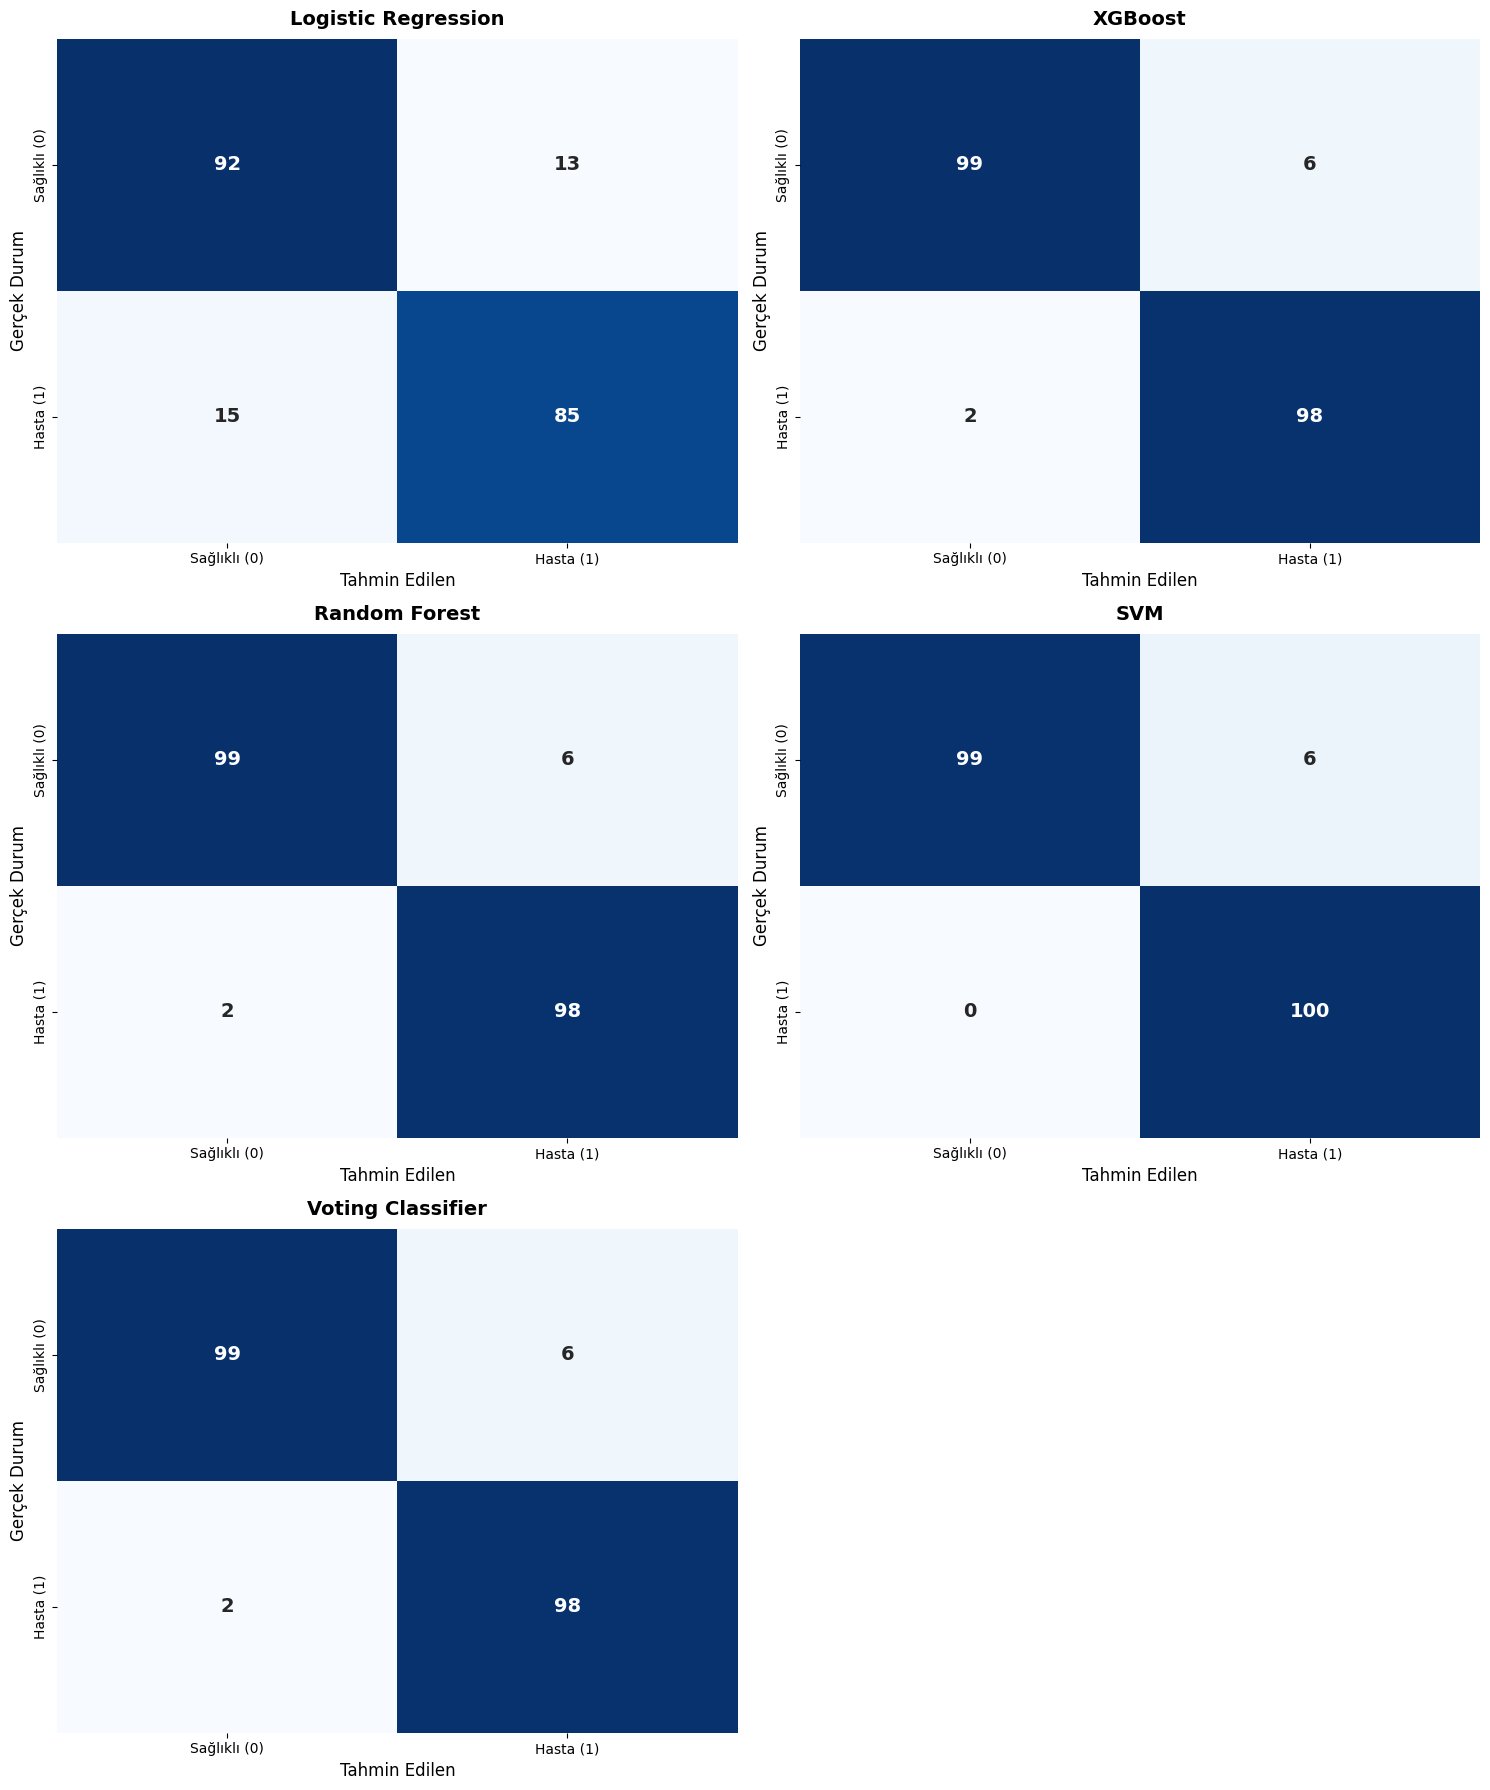

In [205]:
# Confusion Matrix
plt.figure(figsize=(15, 18))
n_models = len(trained_models)
rows = (n_models // 2) + (n_models % 2)

for i, (name, model) in enumerate(trained_models.items(), 1):
    plt.subplot(rows, 2, i)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={'size': 14, 'weight': 'bold'})
    plt.title(f'{name}', fontsize=14, fontweight='bold', pad=10)
    plt.xlabel('Tahmin Edilen', fontsize=12)
    plt.ylabel('Gerçek Durum', fontsize=12)
    plt.xticks([0.5, 1.5], ['Sağlıklı (0)', 'Hasta (1)'])
    plt.yticks([0.5, 1.5], ['Sağlıklı (0)', 'Hasta (1)'])

plt.tight_layout()
plt.show()

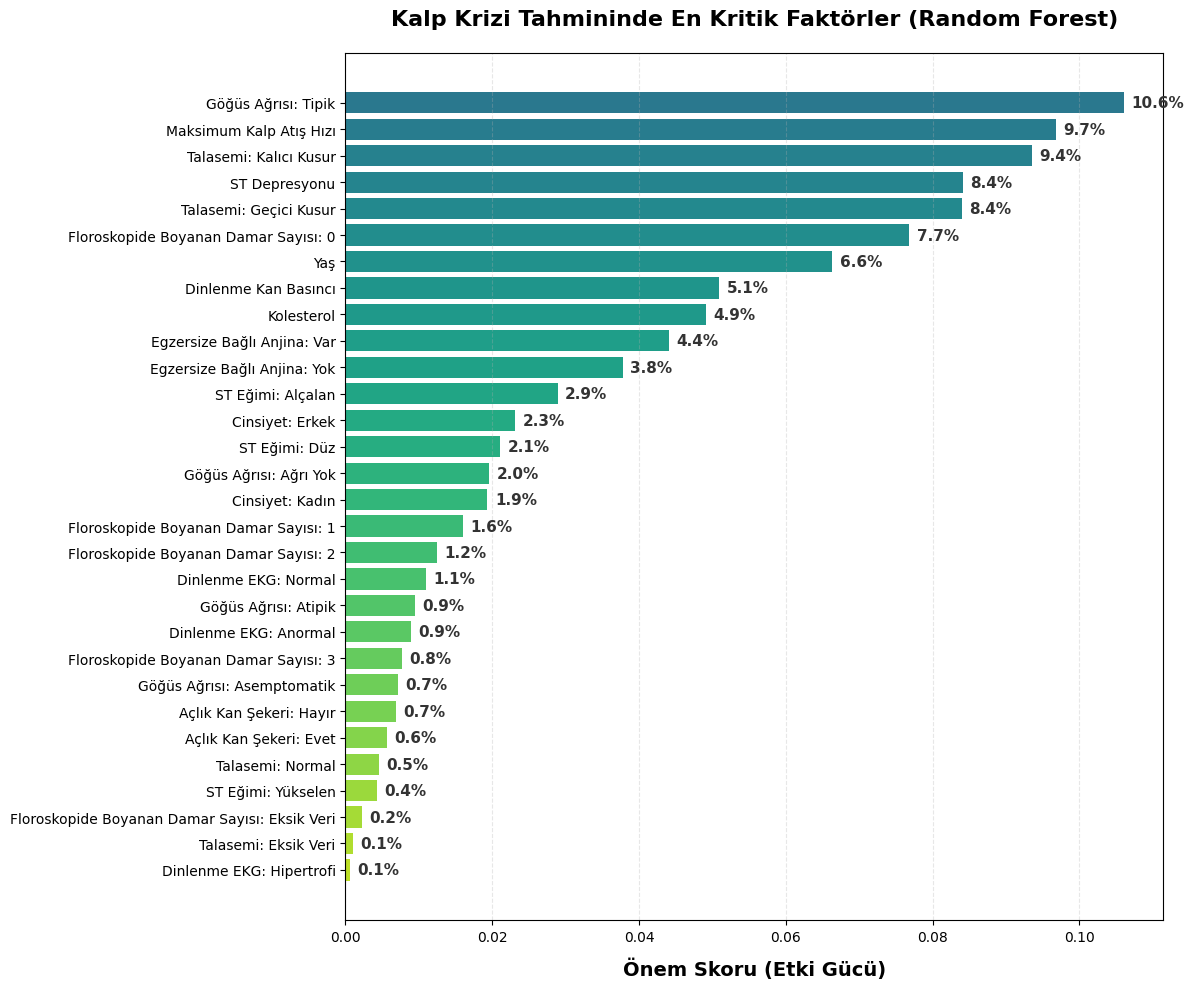


🏆 Random Forest — En Önemli 5 Özellik:
  1. Göğüs Ağrısı: Tipik (Skor: 0.1061)
  2. Maksimum Kalp Atış Hızı (Skor: 0.0968)
  3. Talasemi: Kalıcı Kusur (Skor: 0.0936)
  4. ST Depresyonu (Skor: 0.0841)
  5. Talasemi: Geçici Kusur (Skor: 0.0840)


In [206]:
rf_model = trained_models['Random Forest']
importances = rf_model.feature_importances_
feature_names = X.columns

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

label_map = {
    'cp_0': 'Göğüs Ağrısı: Tipik',
    'cp_1': 'Göğüs Ağrısı: Atipik',
    'cp_2': 'Göğüs Ağrısı: Ağrı Yok',
    'cp_3': 'Göğüs Ağrısı: Asemptomatik',
    'thal_0': 'Talasemi: Eksik Veri',
    'thal_1': 'Talasemi: Normal',
    'thal_2': 'Talasemi: Kalıcı Kusur',
    'thal_3': 'Talasemi: Geçici Kusur',
    'ca_0': 'Floroskopide Boyanan Damar Sayısı: 0',
    'ca_1': 'Floroskopide Boyanan Damar Sayısı: 1',
    'ca_2': 'Floroskopide Boyanan Damar Sayısı: 2',
    'ca_3': 'Floroskopide Boyanan Damar Sayısı: 3',
    'ca_4': 'Floroskopide Boyanan Damar Sayısı: Eksik Veri',
    'oldpeak': 'ST Depresyonu',
    'thalach': 'Maksimum Kalp Atış Hızı',
    'age': 'Yaş',
    'chol': 'Kolesterol',
    'trestbps': 'Dinlenme Kan Basıncı',
    'sex_0': 'Cinsiyet: Kadın',
    'sex_1': 'Cinsiyet: Erkek',
    'exang_0': 'Egzersize Bağlı Anjina: Yok',
    'exang_1': 'Egzersize Bağlı Anjina: Var',
    'slope_0': 'ST Eğimi: Yükselen',
    'slope_1': 'ST Eğimi: Düz',
    'slope_2': 'ST Eğimi: Alçalan',
    'fbs_0': 'Açlık Kan Şekeri: Hayır',
    'fbs_1': 'Açlık Kan Şekeri: Evet',
    'restecg_0': 'Dinlenme EKG: Normal',
    'restecg_1': 'Dinlenme EKG: Anormal',
    'restecg_2': 'Dinlenme EKG: Hipertrofi'
}

feature_importance['readable_name'] = feature_importance['feature'].map(label_map).fillna(feature_importance['feature'])
plt.figure(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0.4, 0.9, len(feature_importance)))

bars = plt.barh(feature_importance['readable_name'], feature_importance['importance'], color=colors)
plt.xlabel('Önem Skoru (Etki Gücü)', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('', fontsize=13)
plt.title('Kalp Krizi Tahmininde En Kritik Faktörler (Random Forest)', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()

for i, (bar, val) in enumerate(zip(bars, feature_importance['importance'])):
    plt.text(val + 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.1%}',
             va='center', fontsize=11, fontweight='bold', color='#333333')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n🏆 Random Forest — En Önemli 5 Özellik:")
for i, (idx, row) in enumerate(feature_importance.head().iterrows(), 1):
    print(f"  {i}. {row['readable_name']} (Skor: {row['importance']:.4f})")

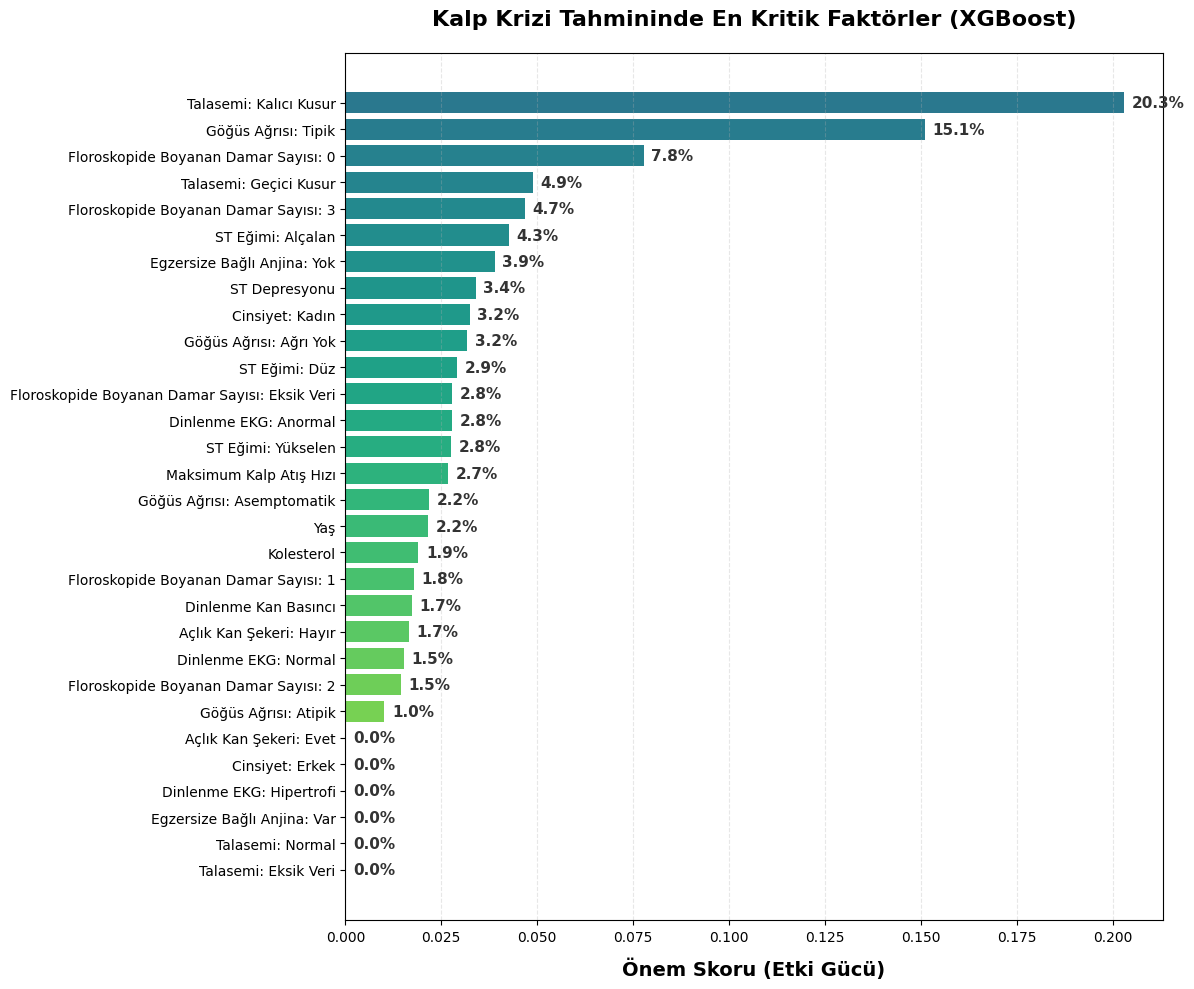


🏆 XGBoost — En Önemli 5 Özellik:
  1. Talasemi: Kalıcı Kusur (Skor: 0.2029)
  2. Göğüs Ağrısı: Tipik (Skor: 0.1510)
  3. Floroskopide Boyanan Damar Sayısı: 0 (Skor: 0.0778)
  4. Talasemi: Geçici Kusur (Skor: 0.0488)
  5. Floroskopide Boyanan Damar Sayısı: 3 (Skor: 0.0468)


In [207]:
rf_model = trained_models['XGBoost']
importances = rf_model.feature_importances_
feature_names = X.columns

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

label_map = {
    'cp_0': 'Göğüs Ağrısı: Tipik',
    'cp_1': 'Göğüs Ağrısı: Atipik',
    'cp_2': 'Göğüs Ağrısı: Ağrı Yok',
    'cp_3': 'Göğüs Ağrısı: Asemptomatik',
    'thal_0': 'Talasemi: Eksik Veri',
    'thal_1': 'Talasemi: Normal',
    'thal_2': 'Talasemi: Kalıcı Kusur',
    'thal_3': 'Talasemi: Geçici Kusur',
    'ca_0': 'Floroskopide Boyanan Damar Sayısı: 0',
    'ca_1': 'Floroskopide Boyanan Damar Sayısı: 1',
    'ca_2': 'Floroskopide Boyanan Damar Sayısı: 2',
    'ca_3': 'Floroskopide Boyanan Damar Sayısı: 3',
    'ca_4': 'Floroskopide Boyanan Damar Sayısı: Eksik Veri',
    'oldpeak': 'ST Depresyonu',
    'thalach': 'Maksimum Kalp Atış Hızı',
    'age': 'Yaş',
    'chol': 'Kolesterol',
    'trestbps': 'Dinlenme Kan Basıncı',
    'sex_0': 'Cinsiyet: Kadın',
    'sex_1': 'Cinsiyet: Erkek',
    'exang_0': 'Egzersize Bağlı Anjina: Yok',
    'exang_1': 'Egzersize Bağlı Anjina: Var',
    'slope_0': 'ST Eğimi: Yükselen',
    'slope_1': 'ST Eğimi: Düz',
    'slope_2': 'ST Eğimi: Alçalan',
    'fbs_0': 'Açlık Kan Şekeri: Hayır',
    'fbs_1': 'Açlık Kan Şekeri: Evet',
    'restecg_0': 'Dinlenme EKG: Normal',
    'restecg_1': 'Dinlenme EKG: Anormal',
    'restecg_2': 'Dinlenme EKG: Hipertrofi'
}

feature_importance['readable_name'] = feature_importance['feature'].map(label_map).fillna(feature_importance['feature'])
plt.figure(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0.4, 0.9, len(feature_importance)))

bars = plt.barh(feature_importance["readable_name"], feature_importance["importance"], color=colors)

plt.xlabel("Önem Skoru (Etki Gücü)", fontsize=14, fontweight="bold", labelpad=10)
plt.title("Kalp Krizi Tahmininde En Kritik Faktörler (XGBoost)", fontsize=16, fontweight="bold", pad=20)
plt.gca().invert_yaxis()

for i, (bar, val) in enumerate(zip(bars, feature_importance["importance"])):
    plt.text(val + 0.002, bar.get_y() + bar.get_height()/2,
             f"{val:.1%}",
             va="center", fontsize=11, fontweight="bold", color='#333333')

plt.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print("\n🏆 XGBoost — En Önemli 5 Özellik:")
for i, (idx, row) in enumerate(feature_importance.head().iterrows(), 1):
    print(f"  {i}. {row['readable_name']} (Skor: {row['importance']:.4f})")

**YENİ HASTA TAHMİN SİSTEMİ**

In [209]:
def yeni_hasta_tahmini():
    print("="*80)
    print("Lütfen belirtilen aralıklarda sayısal değerler giriniz.\n")

    # Değişkenler, Açıklamalar ve Tıbbi Sınırlar (Min-Max)
    input_specs = {
        'age':      {'label': 'Yaş', 'min': 1, 'max': 120},
        'sex':      {'label': 'Cinsiyet (1: Erkek, 0: Kadın)', 'min': 0, 'max': 1},
        'cp':       {'label': 'Göğüs Ağrısı Tipi (0: Tipik, 1: Atipik, 2: Ağrı Yok, 3: Asemptomatik )', 'min': 0, 'max': 3},
        'trestbps': {'label': 'Dinlenme Kan Basıncı (Tansiyon) (80-220)', 'min': 80, 'max': 220},
        'chol':     {'label': 'Kolesterol (100-600)', 'min': 100, 'max': 600},
        'fbs':      {'label': 'Açlık Kan Şekeri > 120 (1: Evet, 0: Hayır)', 'min': 0, 'max': 1},
        'restecg':  {'label': 'Dinlenme EKG (0: Normal 1: Anormal 2: Hipertrofi)', 'min': 0, 'max': 2},
        'thalach':  {'label': 'Maksimum Nabız (50-220)', 'min': 50, 'max': 220},
        'exang':    {'label': 'Egzersiz Anjini (1: Evet, 0: Hayır)', 'min': 0, 'max': 1},
        'oldpeak':  {'label': 'Egzersiz ST Depresyonu (0.0 - 6.5)', 'min': 0.0, 'max': 6.5},
        'slope':    {'label': 'ST Eğimi (0: Yukarı, 1: Düz, 2: Alçalan)', 'min': 0, 'max': 2},
        'ca':       {'label': 'Floroskopide Boyanan Damar Sayısı (0-3)', 'min': 0, 'max': 3},
        'thal':     {'label': 'Talasemi (1: Normal, 2: Kalıcı Kusur, 3: Geçici Kusur)', 'min': 1, 'max': 3}
    }

    input_data = {}
    for col, specs in input_specs.items():
        while True:
            try:
                val_str = input(f"👉 {specs['label']:<65} giriniz: ")
                val = float(val_str)

                if specs['min'] <= val <= specs['max']:
                    input_data[col] = val
                    break
                else:
                    print(f"   ⚠️ UYARI: Lütfen {specs['min']} ile {specs['max']} arasında bir değer giriniz!")
            except ValueError:
                print("   ❌ HATA: Lütfen geçerli bir sayı giriniz!")

    # Veriyi DataFrame'e çevir
    input_df = pd.DataFrame([input_data])

    # Kategorik Dönüşüm
    cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    available_nominal = [c for c in cat_cols if c in input_df.columns]
    input_df = pd.get_dummies(input_df, columns=available_nominal, drop_first=True)

    # Sütun Eşitleme
    model_columns = X.columns
    input_df = input_df.reindex(columns=model_columns, fill_value=0)

    # Ölçeklendirme
    new_data_scaled = scaler.transform(input_df)

    print("\n" + "="*80)
    print("🤖 MODEL TAHMİN SONUÇLARI")
    print("="*80)
    print(f"{'Model Adı':<25} | {'Tahmin':<22} | {'Güven Oranı':<20}")
    print("-" * 65)

    for name, model in trained_models.items():
        prediction = model.predict(new_data_scaled)[0]
        prob_values = model.predict_proba(new_data_scaled)[0]
        guven = prob_values[prediction] * 100

        if prediction == 1:
            durum = "KALP HASTALIĞI VAR 🚨"
        else:
            durum = "SAĞLIKLI ✅"

        print(f"{name:<25} | {durum:<20} | %{guven:.2f} Oran.")

    print("-" * 65)
# Fonksiyonu çalıştır
yeni_hasta_tahmini()

Lütfen belirtilen aralıklarda sayısal değerler giriniz.

👉 Yaş                                                               giriniz: 67
👉 Cinsiyet (1: Erkek, 0: Kadın)                                     giriniz: 1
👉 Göğüs Ağrısı Tipi (0: Tipik, 1: Atipik, 2: Ağrı Yok, 3: Asemptomatik ) giriniz: 0
👉 Dinlenme Kan Basıncı (Tansiyon) (80-220)                          giriniz: 160
👉 Kolesterol (100-600)                                              giriniz: 286
👉 Açlık Kan Şekeri > 120 (1: Evet, 0: Hayır)                        giriniz: 1
👉 Dinlenme EKG (0: Normal 1: Anormal 2: Hipertrofi)                 giriniz: 2
👉 Maksimum Nabız (50-220)                                           giriniz: 108
👉 Egzersiz Anjini (1: Evet, 0: Hayır)                               giriniz: 1
👉 Egzersiz ST Depresyonu (0.0 - 6.5)                                giriniz: 3.0
👉 ST Eğimi (0: Yukarı, 1: Düz, 2: Alçalan)                          giriniz: 2
👉 Floroskopide Boyanan Damar Sayısı (0-3)                   

In [211]:
yeni_hasta_tahmini()

Lütfen belirtilen aralıklarda sayısal değerler giriniz.

👉 Yaş                                                               giriniz: 35
👉 Cinsiyet (1: Erkek, 0: Kadın)                                     giriniz: 0
👉 Göğüs Ağrısı Tipi (0: Tipik, 1: Atipik, 2: Ağrı Yok, 3: Asemptomatik ) giriniz: 2
👉 Dinlenme Kan Basıncı (Tansiyon) (80-220)                          giriniz: 118
👉 Kolesterol (100-600)                                              giriniz: 185
👉 Açlık Kan Şekeri > 120 (1: Evet, 0: Hayır)                        giriniz: 0
👉 Dinlenme EKG (0: Normal 1: Anormal 2: Hipertrofi)                 giriniz: 0
👉 Maksimum Nabız (50-220)                                           giriniz: 175
👉 Egzersiz Anjini (1: Evet, 0: Hayır)                               giriniz: 0
👉 Egzersiz ST Depresyonu (0.0 - 6.5)                                giriniz: 0.0
👉 ST Eğimi (0: Yukarı, 1: Düz, 2: Alçalan)                          giriniz: 0
👉 Floroskopide Boyanan Damar Sayısı (0-3)                   